In [1]:
import pandas as pd
import logging
import torch
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import DataLoader
import seisbench
import seisbench.models as sbm
from seisLM.evaluation import pick_eval

from seisLM.model import supervised_models


data_aliases = {
    "ethz": "ETHZ",
    "geofon": "GEOFON",
    "stead": "STEAD",
    "neic": "NEIC",
    "iquique": "Iquique",
    # "scedc": "SCEDC", # TODO: Something is wrong with this dataset
    # "instance": "InstanceCountsCombined", # TODO: Something is wrong with this dataset
}

In [2]:
model_name = 'PhaseNet'
# data_name = 'ethz'

for data_name in data_aliases.keys():
  pick_eval.save_pick_predictions(
    data_name=data_name,
    model_name=model_name,
    targets=f'/home/liu0003/Desktop/projects/seisLM/targets/{data_name}',
    sets='dev,test',
)

2024-05-31 20:53:06,671 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb


Model trained on ETHZ for 100 epochs with a learning rate of 0.01.
Threshold selected for optimal F1 score on in-domain evaluation. Depending on the target region, the thresholds might need to be adjusted.
When using this model, please reference the SeisBench publications listed at https://github.com/seisbench/seisbench

Jannes Münchmeyer, Jack Woollam (munchmej@gfz-potsdam.de, jack.woollam@kit.edu)


Preloading waveforms:   3%|▎         | 114/3632 [00:01<00:30, 113.63it/s]

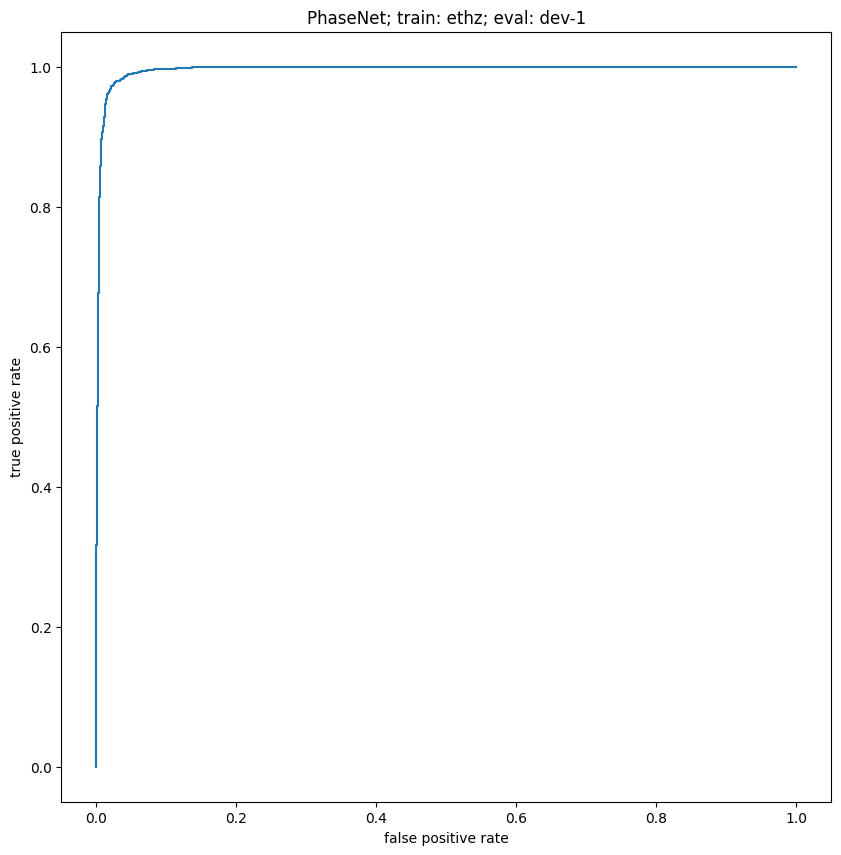

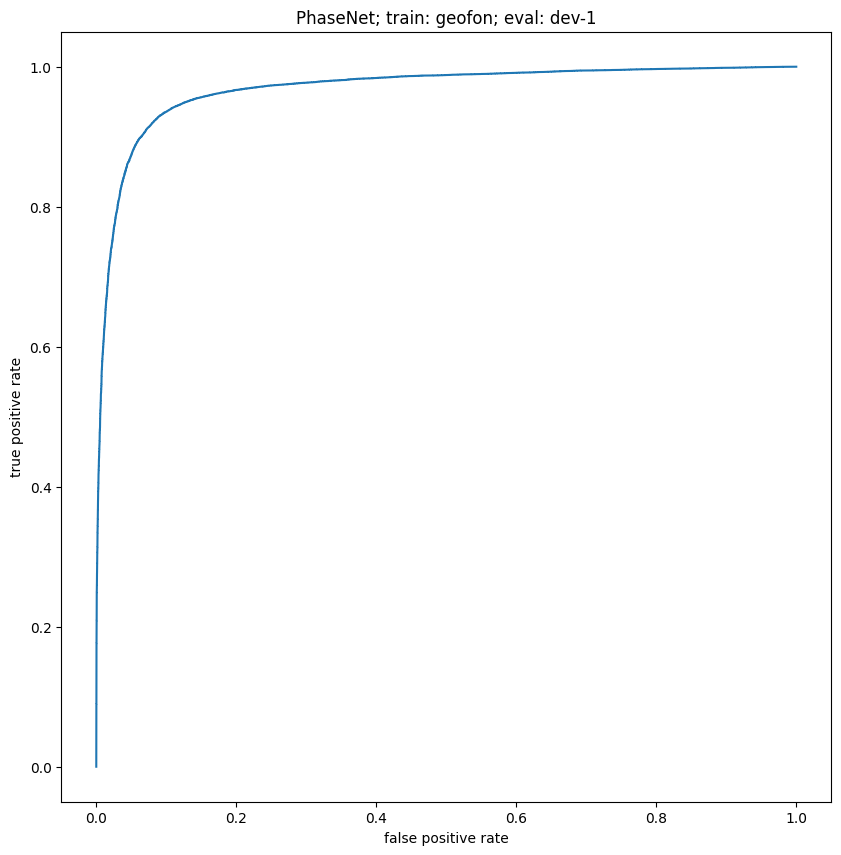

In [ ]:
from seisLM.utils.project_path import gitdir
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt


task = 1 # '23'
eval_set = 'dev' #'test'


for data_name in data_aliases.keys():

  pred_path = (
    Path(gitdir())
    / "evaluation_results"
    / f"{model_name}_{data_name}"
    / f"{eval_set}_task{task}.csv"
  )


  pred = pd.read_csv(pred_path)

  pred["trace_type_bin"] = pred["trace_type"] == "earthquake"

  fpr, tpr, _ = roc_curve(pred["trace_type_bin"], pred["score_detection"])

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111)
  ax.plot(fpr, tpr)
  ax.set_aspect("equal")

  ax.set_xlabel("false positive rate")
  ax.set_ylabel("true positive rate")
  ax.set_title(f"{model_name}; train: {data_name}; eval: {eval_set}-{task}")


dataset: ethz | phase P | MAE 0.08992850213431307
dataset: ethz | phase S | MAE 0.11450471614132407
dataset: geofon | phase P | MAE 0.4063038934977657
dataset: geofon | phase S | MAE 1.1431762395382397


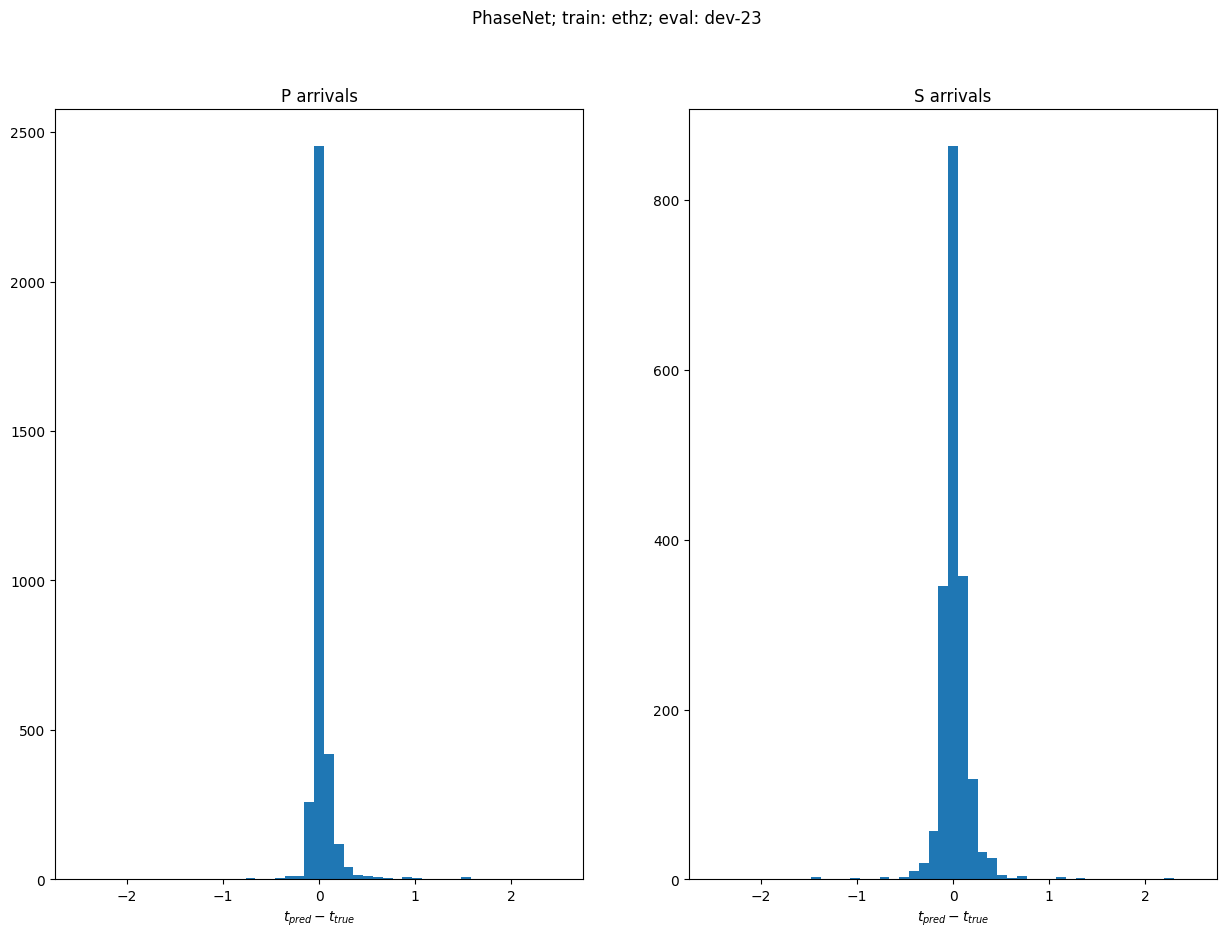

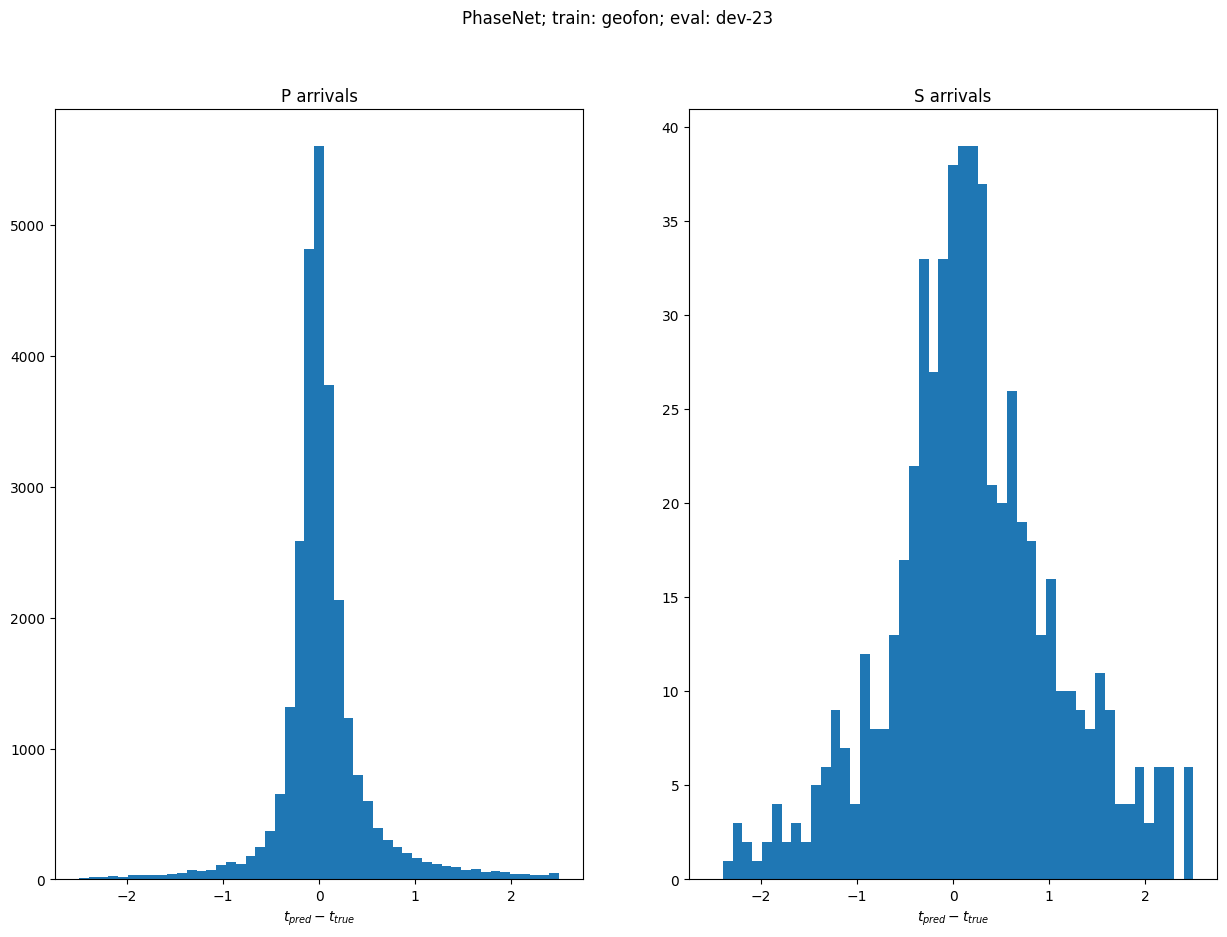

In [ ]:
import numpy as np

task = 23
eval_set = 'dev' #'test'

for data_name in data_aliases.keys():

  pred_path = (
    Path(gitdir())
    / "evaluation_results"
    / f"{model_name}_{data_name}"
    / f"{eval_set}_task{task}.csv"
  )

  pred = pd.read_csv(pred_path)


  fig = plt.figure(figsize=(15, 10))
  axs = fig.subplots(1, 2)

  for i, phase in enumerate(["P", "S"]):
      ax = axs[i]
      ax.set_title(f"{phase} arrivals")
      pred_phase = pred[pred["phase_label"] == phase]
      pred_col = f"{phase.lower()}_sample_pred"

      diff = (pred_phase[pred_col] - pred_phase["phase_onset"]) / pred_phase["sampling_rate"]

      print(f'dataset: {data_name} | phase {phase} | MAE {diff.abs().mean()}')
      bins = np.linspace(-2.5, 2.5, 50)
      ax.hist(diff, bins=bins)
      ax.set_xlabel("$t_{pred} - t_{true}$")
  plt.suptitle(f"{model_name}; train: {data_name}; eval: {eval_set}-{task}")
